## Machine Translation using Seq2Seq models with Attention Mechanism

In this notebook, I will be demostration English to spanish machine translation task using a LSTM based seq2seq model with Attention Mechanism. I will be demostration English to spanish machine translation task using a LSTM based seq2seq model with Attention Mechanism. The whole model can be thought of as a seq2seq translation model with an Attention layer between the decoder and encoder.

So, What is Attention and Why do we need it in the first place?

The answer to this question itself is another quetion, Why do we need LSTM ?

LSTM helps to mitigate the vanishing gradient problem and thus enabling the model to learn very long seqences, but how long? They also have a limit right? This is where attention comes in.

So, coming back to the encoder decoder model. Notice that we have only used the finial state from the encoder in the previous model assuming that the model has successfuly encoded the information regarding the entire seqence and so taking the final hidden state is sufficient. Although this techniqe works well in several cases, as I said before, they also have limitiations. The biggest limitation is the seqence length itself. Consider the example of a machine translation task:

How would a human translator translate a text? Would he/she take the entire input all at once or translate it part by part giving attention to the relevent part one by one? Naturally the second option right? The idea of attention mechanism is exactly this. For each output seqence, consider only the relevent input seqence, It's as simple as this.

And how would we do this? Simply use a softmax layer in between encoder and decoder. That is, we add another neural network, not a recurrent one but a simple dense layer or multiple dense layers between encoder and decoder. The final layer of this neural network must be a softmax layer, that' it. We are using a neural network so that the whold model is end to end differentible and we can train the whole model as one using back propagation.

The inputs to this attention layer will be a concatenation of the t-1 state from the decoder and each hidden state of the encoder. i.e, we take a copy of a single seqence from the decoder and repeatedly concatenate it with each seqence from the encoder and feed it to the attention layer. This must be reapeated for the entire decoder seqences. The outputs from the attention layer will contain the attention weights. Next, we take a dot product between these attention weigts and each encoder hidden states and finally a context vector is produced by taking a weighted sum of this dot product operation. If we are using teacher forcing, this context vector is again concatenated with the inputs and fed into the decoder LSTM.

To summerize, the input to decoder LSTM in this case will be the Context vector and not the final hidden state from the encoder LSTM. Therefore, we will initalize the first hidden and cell states seperately so that we will have control of these states since we need them for our genrerative model. Also, here, will return the entire seqence from the encoder LSTM since they are needed to calculate the attention weights.

Link to download the pre-trained word embeddings: http://nlp.stanford.edu/data/glove.6B.zip

Link to download the translation training texts: http://www.manythings.org/anki/

In [53]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Basic Imports


In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

### Config

In [3]:
# config
BATCH_SIZE = 64
EPOCHS = 18
LATENT_DIM = 400
LATENT_DIM_DECODER = 400 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 20000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
DATA_PATH = '/content/drive/My Drive/Dataset/spa-eng/spa.txt'
WORD2VEC_PATH = '/content/drive/My Drive/Dataset/WordVectors/glove.6B.100d.txt'

### Softmax Over time

We must take the attention softmax over the time axis, which is the 2nd axis. In Keras, by default the softmax is taken along the last axis. Therefore, we will use a custome function to perform this operation.

Note: In the lastest version of Keras we can specify this by passing in the axis argument while calling the softmax function.


In [4]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

### Loading data

In [5]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [6]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open("spa-eng/spa.txt",encoding="utf-8"):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))


num samples: 20000


### Tokenizing

In [7]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [8]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 3767 unique input tokens.


In [9]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [10]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [11]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 10516 unique output tokens.


In [12]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [13]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

### Padding

In [14]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape: (20000, 6)
encoder_data[0]: [ 0  0  0  0  0 22]
decoder_data[0]: [   2 2851    0    0    0    0    0    0    0    0    0    0    0]
decoder_data.shape: (20000, 13)


In [15]:
#with io.open('/content/gdrive/Place/Of/Your/Choice/glove.6B.300d.txt', encoding='utf8') as f:


### Loading Glove Vectors


In [16]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("../Toxic-Comment-Classification/WordVectors/glove.6B.100d.txt" , encoding='utf8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


### Creating Embedding matrix

In [17]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



Filling pre-trained embeddings...


### Building Model

#### Embedding layer

In [18]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


W0509 22:54:01.162398 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



#### One hot targets

In [19]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [20]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word > 0:
      decoder_targets_one_hot[i, t, word] = 1

#### Encoder


In [21]:
# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)

W0509 22:54:01.449020 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0509 22:54:01.461252 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0509 22:54:01.474920 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0509 22:54:01.474920 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.




#### Decoder
The decoder and Attention mechanism is tightly coupled as if they both form a single layer

In [22]:
# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

In [23]:
# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)



#### The Attention Mechanism
###### Setting up attention layers
The attention layers must be global because they must be used again and again for the entire length of output seqence.

In [24]:
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [25]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [26]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

In [27]:
initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

Unlike the usual seq2seq model the output is not directly taken from the decoder LSTM, here we must loop through the entire output seqences.



In [28]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)


Since we looped through the entire output seqence, our final output will be of shape (output_seq, batch_size, output_vocab). This is not what we want, threfore we must transpose the output vector into the shape (batch_size,output_seq,output_vocab).



In [29]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


In Keras every operation must be a layer, so make tha above function a layer

#### Create the Model

In [30]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

In [31]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [32]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [33]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

W0509 22:54:09.961210 33168 deprecation_wrapper.py:119] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [34]:
# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

W0509 22:54:10.543700 33168 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16000 samples, validate on 4000 samples
Epoch 1/18
16000/16000 [==============================] - 70s 4ms/step - loss: 6.3807 - acc: 0.2434 - val_loss: 6.5619 - val_acc: 0.2129
Epoch 2/18
16000/16000 [==============================] - 67s 4ms/step - loss: 5.8241 - acc: 0.2599 - val_loss: 6.5597 - val_acc: 0.2395
Epoch 3/18
16000/16000 [==============================] - 51s 3ms/step - loss: 5.6363 - acc: 0.2805 - val_loss: 6.4843 - val_acc: 0.2451
Epoch 4/18
16000/16000 [==============================] - 51s 3ms/step - loss: 5.5056 - acc: 0.2841 - val_loss: 6.4200 - val_acc: 0.2471
Epoch 5/18
16000/16000 [==============================] - 56s 4ms/step - loss: 5.3844 - acc: 0.2904 - val_loss: 6.3143 - val_acc: 0.2552
Epoch 6/18
16000/16000 [==============================] - 52s 3ms/step - loss: 5.2132 - acc: 0.2957 - val_loss: 5.8843 - val_acc: 0.2621
Epoch 7/18
16000/16000 [==============================] - 52s 3ms/step - loss: 4.5888 - acc: 0.3439 - val_loss: 5.0774 - val_acc:

#### Plotting loss and accuracy 

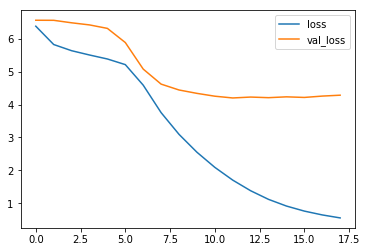

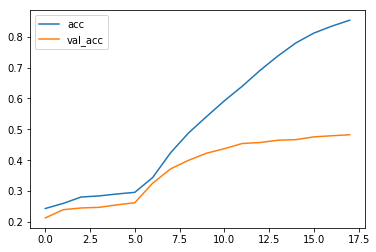

In [35]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

#### Generative Model


In [36]:
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [37]:
# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [38]:
# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

In [39]:
# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

In [40]:
# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [41]:
# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

In [42]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [43]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

In [44]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: Is it poisonous?
Predicted translation: ¿es venenoso?
Actual translation: ¿Es venenoso? <eos>
Continue? [Y/n]y
-
Input sentence: I'll bring lunch.
Predicted translation: yo voy a traer almuerzo.
Actual translation: Yo voy a traer almuerzo. <eos>
Continue? [Y/n]y
-
Input sentence: Please wake up.
Predicted translation: despiértese, por favor.
Actual translation: Despiértese, por favor. <eos>
Continue? [Y/n]y
-
Input sentence: I looked around me.
Predicted translation: me hice por mí.
Actual translation: He mirado a mi alrededor. <eos>
Continue? [Y/n]y
-
Input sentence: I'm sick.
Predicted translation: estoy enferma.
Actual translation: Estoy enferma. <eos>
Continue? [Y/n]y
-
Input sentence: I have a pen.
Predicted translation: tengo un pluma.
Actual translation: Tengo una pluma. <eos>
Continue? [Y/n]y
-
Input sentence: Tom described Mary.
Predicted translation: tom no era mary.
Actual translation: Tom describió a Mary. <eos>
Continue? [Y/n]y
-
Input sentence: You're a 

In [57]:
encoder_model.save(       "Models/Machine_translation_encoder_18eph_T1",      include_optimizer=True)


In [58]:
decoder_model.save(       "Models/Machine_translation_decoder_18eph_T1",      include_optimizer=True)


C:\Users\Parth\Anaconda3\envs\python3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's0:0' shape=(?, 400) dtype=float32>, <tf.Tensor 'c0:0' shape=(?, 400) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
